# Voice Data Detects Disease


The data that we will be looking at was collected in a study. The study recruited adult subjects ranging from 18 to 70 years old who were capable of engaging in the research's required stages. Exclusion criteria included minors and individuals over 70, those with vocal fold disorders, upper respiratory tract infections, or neurological issues. Recordings were sampled at 8000 Hz with a 32-bit resolution and underwent noise-filtering to ensure clarity. Subjects were instructed to speak at a regular conversational volume and underwent several practice attempts prior to the final recording.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
#wfdb is the package that can read WFDB format file
import wfdb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

We need to read the information text files first associated with all 208 subjects


In [2]:
def read_info_file(file_path):
    data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        line = line.strip()
        if line:
            if ':' not in line:  # Check if the line contains a colon
                continue  # If not, skip this line
            key, value = line.split(':', 1)  # Split only on the first colon
            key = key.strip()
            value = value.strip()
            if value.lower() == 'nu' or not value:  # Check for 'NU' or empty string
                value = np.nan  # Replace 'NU' with NaN
            else:
                try:
                    # Remove units and convert to float
                    value = float(value.replace('gr', '').replace('litres', '').replace(',', '.'))
                except ValueError:
                    pass  # Keep as string if not a number
            data[key] = value
    return data


The voice recordings are provided in WFDB format. Each of the 208 subjects have a 
.dat file associated with them. This is the voice recording data, in order to read this data we have to use the wfdb package


In [3]:
def read_signal_files(dat_file_path, hea_file_path):
    # Load the record using wfdb
    record = wfdb.rdrecord(dat_file_path.replace('.dat', ''))
    
    # Extract the signal and annotations from the record
    signal = record.p_signal.flatten()  # Assuming it's a single-channel recording
    
    # Calculate basic statistics on the signal
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    max_signal = np.max(signal)
    min_signal = np.min(signal)
    
    # Create a dictionary with the extracted data
    signal_data = {
        'Mean_Signal': mean_signal,
        'Std_Signal': std_signal,
        'Max_Signal': max_signal,
        'Min_Signal': min_signal
    }
    
    return signal_data

Implement a loop to start reading all the files for the 208 subjects within the databse


In [4]:
# Base path to the voice-database folder
base_path = 'voice-database'

# Initialize a list to hold all combined subject data
all_subject_data = []

# Loop over all subject IDs
for subject_id in range(1, 209):  # Assuming IDs from 001 to 208
    # Construct file paths
    info_path = os.path.join(base_path, f'voice{subject_id:03}-info.txt')
    dat_path = os.path.join(base_path, f'voice{subject_id:03}.dat')
    hea_path = os.path.join(base_path, f'voice{subject_id:03}.hea')
    txt_path = os.path.join(base_path, f'voice{subject_id:03}.txt')
    
    # Read and process info file
    info_data = read_info_file(info_path)
    
    # Read and process signal files (.dat and .hea)
    signal_data = read_signal_files(dat_path, hea_path)
    
    # Combine the info and signal data into one record
    combined_data = info_data.copy()
    combined_data.update(signal_data) 
    
    # Append the combined data to the list
    all_subject_data.append(combined_data)

# Convert the list to a DataFrame
all_subjects_df = pd.DataFrame(all_subject_data)


**Exploring the Dataframe we have crated.**

Use the .head() funtion to display the first few rows of the DataFrame.


In [5]:
all_subjects_df.head()

,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,Amount of water's litres drink every day,...,Carbonated beverages,Tomatoes,Coffee,Chocolate,Soft cheese,Citrus fruits,Mean_Signal,Std_Signal,Max_Signal,Min_Signal
0,32.0,m,hyperkinetic dysphonia,Researcher,15.0,5.0,no,NaN,casual drinker,1.5,...,almost never,sometimes,almost always,almost never,sometimes,sometimes,-0.000478,0.130235,0.590118,-0.462646
1,55.0,m,healthy,Employee,17.0,12.0,casual smoker,2.0,habitual drinker,0.5,...,almost always,sometimes,sometimes,sometimes,almost always,almost always,-0.000198,0.290999,0.906860,-0.872040
2,34.0,m,hyperkinetic dysphonia (nodule),Researcher,42.0,26.0,no,NaN,casual drinker,1.5,...,sometimes,sometimes,almost always,sometimes,almost always,almost never,-0.000311,0.259768,0.925568,-0.756714
3,28.0,f,hypokinetic dysphonia,Researcher,20.0,9.0,casual smoker,NaN,casual drinker,1.0,...,almost never,sometimes,always,sometimes,almost always,sometimes,-0.000523,0.051166,0.185791,-0.151184
4,54.0,f,hypokinetic dysphonia,Researcher,39.0,23.0,no,NaN,casual drinker,1.5,...,never,sometimes,never,sometimes,sometimes,almost always,-0.000494,0.185828,0.586456,-0.534973


Use the .info() function with the dataframe. This will provide a concise summary of the DataFrame, including the number of non-null entries in each column and data types.


In [6]:
all_subjects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       208 non-null    float64
 1   Gender                                    208 non-null    object 
 2   Diagnosis                                 208 non-null    object 
 3   Occupation status                         167 non-null    object 
 4   Voice Handicap Index (VHI) Score          208 non-null    float64
 5   Reflux Symptom Index (RSI) Score          208 non-null    float64
 6   Smoker                                    208 non-null    object 
 7   Number of cigarettes smoked per day       41 non-null     float64
 8   Alcohol consumption                       208 non-null    object 
 9   Amount of water's litres drink every day  208 non-null    float64
 10  Eating habits                         

After using the .info() function we can see that the Dataframe has eating habits, however by a simple look at the subject data info.txt files we can see that they don't have anything for that section. So we should remove this from our dataset.

In [7]:
all_subjects_df = all_subjects_df.drop(columns=['Eating habits'])

Use the .describe() function with the Dataframe. This gives a statistical summary of the DataFrame, useful for numerical fields.


In [8]:
# Drop the 'count' row from the resulting DataFrame this will make it now show when we use the describe function 
all_subjects_df.describe().drop('count')

,Age,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Number of cigarettes smoked per day,Amount of water's litres drink every day,Mean_Signal,Std_Signal,Max_Signal,Min_Signal
mean,44.086538,23.846154,11.990385,15.292683,1.431490,-0.000397,0.196733,0.740366,-0.573302
std,13.743763,23.588366,8.302837,8.629148,0.471206,0.000103,0.070158,0.210519,0.213895
min,18.000000,0.000000,0.000000,2.000000,0.250000,-0.000615,0.038769,0.117798,-1.000000
25%,32.750000,5.000000,5.000000,10.000000,1.000000,-0.000477,0.150141,0.609100,-0.746819
50%,45.000000,17.000000,12.000000,15.000000,1.500000,-0.000416,0.195999,0.782242,-0.575638
75%,55.000000,35.000000,18.000000,20.000000,2.000000,-0.000326,0.252970,0.918266,-0.421722
max,70.000000,106.000000,41.000000,40.000000,2.500000,-0.000111,0.348097,0.999969,-0.102875


We wanna find out how many features our dataframe has so let's use .shape function. 

In [9]:
num_features = all_subjects_df.shape[1]
print(f"Number of features: {num_features}")

Number of features: 20


Let's revisit our function read_signal_files that reads the voice recordinds of the 208 subjects in our dataset. Why do we store 4 things(Mean Signal, Standar Deviation of Signal, Max Signal, and Minimum Signal) for each of the 208 subjects? Let's look at these more in detail. 

*Mean Signal:* The mean signal represents the average amplitude of the voice recording. It can provide insights into the overall loudness and energy of the voice sample. Variations in the mean signal can be indicative of vocal health, where unusually high or low average amplitudes may suggest possible voice disorders.

*Standard Deviation of Signal:* This measures the amount of variation or dispersion from the mean signal. A high standard deviation indicates that the signal varies widely from the mean, which could be a sign of an unstable or inconsistent voice — potentially a symptom of a voice pathology.

*Maximum Signal Amplitude:* The maximum amplitude reflects the loudest part of the voice recording. By identifying the peak amplitude, we can assess the dynamic range of the subject's voice and detect any abnormal vocal efforts or strain.

*Minimum Signal Amplitude:* Conversely, the minimum amplitude can indicate the softest part of the recording. Analyzing both the maximum and minimum amplitudes can give us a better understanding of the subject's vocal range and any difficulties in maintaining vocal intensity.

Lets split our data into training and test sets. We will also change the diagnosis feature to be numeric instead. So diagnosis will now only be 0 or 1. With 0 representing a healthy subject, while 1 will represent a subject with a disease.

In [10]:
from sklearn.model_selection import train_test_split
# Select only the voice data features for X
voice_features = ['Mean_Signal', 'Std_Signal', 'Max_Signal', 'Min_Signal']
X = all_subjects_df[voice_features]

copy_all_subjects_fd = all_subjects_df

# We wanna mark the diagnosis as numbers. 0 = healthy, and if they have any other disease it will be 1
all_subjects_df['Diagnosis'] = all_subjects_df['Diagnosis'].str.lower().str.strip().apply(lambda x: 0 if x == 'healthy' else 1)

# The target variable is Diagnosis since that's what we will be focusing on 
y = all_subjects_df['Diagnosis']

# Splitting the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# We wanna count the number of healthy vs non-healthy subjects 
healthy_count = all_subjects_df['Diagnosis'].value_counts()[0]
non_healthy_count = all_subjects_df['Diagnosis'].value_counts()[1]

print(f'Number of healthy individuals: {healthy_count}')
print(f'Number of non-healthy individuals: {non_healthy_count}')

Number of healthy individuals: 57
Number of non-healthy individuals: 151


Let's visualize if there is a trend between 'Mean_Signal' and 'Diagnosis. Let's do a scatterplot for this.

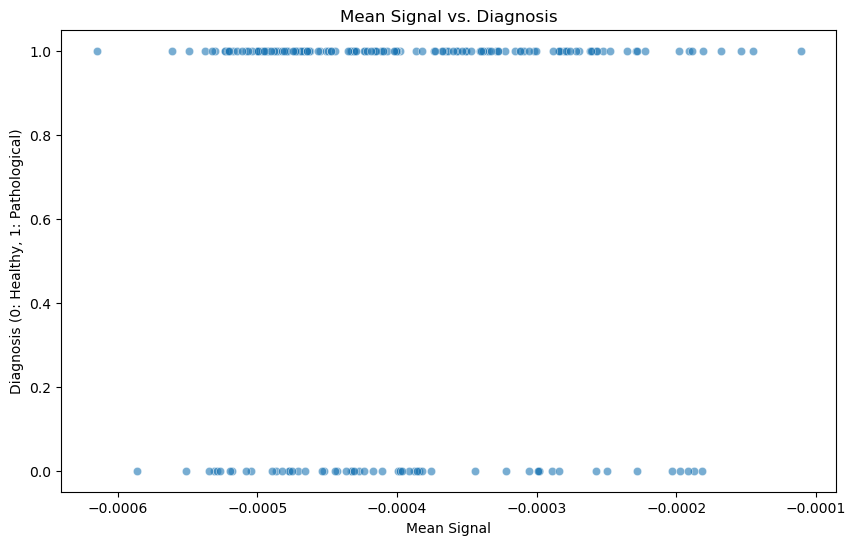

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mean_Signal', y='Diagnosis', data=all_subjects_df, alpha=0.6)
plt.title('Mean Signal vs. Diagnosis')
plt.xlabel('Mean Signal')
plt.ylabel('Diagnosis (0: Healthy, 1: Pathological)')
plt.show()

Lets split our data into training and testing

Accuracy Score: 0.6984126984126984


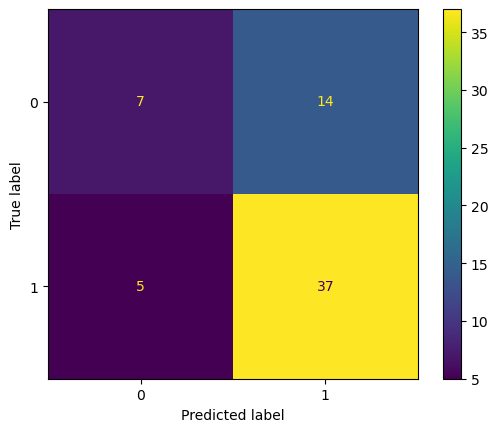

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay


knn = KNeighborsClassifier(n_neighbors=8)

knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy Score: {accuracy}')


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.show()

Initially, our dataset exhibited a significant class imbalance, with 151 non-healthy individuals compared to only 57 healthy ones. Such disproportion can lead to biased model performance, where the model might overly favor the majority class. Before addressing the imbalance, the KNN classifier yielded an accuracy score of approximately 0.69. While accuracy is a useful metric, it can be misleading when dealing with imbalanced datasets, as it doesn't reflect the model's performance on each class separately. Our confusion matrix suggests that the classifier is better at identifying non-healthy individuals than healthy ones, likely due to the class imbalance. This resulted in a higher number of false negatives, this can be concerning because it represnts missed diagnosis which is a big deal.
We will down sample the majority in this case being the non-healthy subjects to try improve our current results. We will see if this makes a difference in our accuracy score and/or confusion matrix 

In [13]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = all_subjects_df[all_subjects_df.Diagnosis == 1]
df_minority = all_subjects_df[all_subjects_df.Diagnosis == 0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # Sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_downsampled.Diagnosis.value_counts())

# We wanna split the downsampled DataFrame
X_downsampled = df_downsampled[voice_features]
y_downsampled = df_downsampled['Diagnosis']

# Split the downsampled data into training and testing sets
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)


Diagnosis
1    57
0    57
Name: count, dtype: int64


After down sampling the majority(subjects with actual diagnosis), we then re apply our model. We will look at the accuracy score and the confusion matrix to see if the results have improved.

Accuracy: 0.6285714285714286


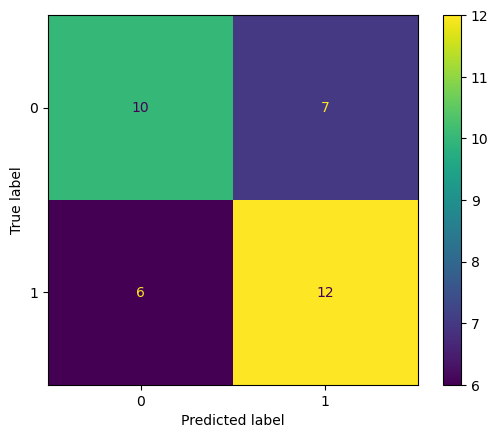

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=8)

# Fit the classifier using the downsampled training set
knn.fit(X_train_down, y_train_down)

# Predict on the downsampled test set
y_pred_down = knn.predict(X_test_down)

# Calculate accuracy and confusion matrix using the downsampled test set
accuracy_down = accuracy_score(y_test_down, y_pred_down)
conf_matrix_down = confusion_matrix(y_test_down, y_pred_down)

print(f'Accuracy: {accuracy_down}')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_down)
disp.plot()
plt.show()


As we can see after downsampling and matching the number of healthy and non-healthy patients, the accuracy of the model actually ended up decreasing. When we look at the different confusion matrices we notice that the model is better at identifying healthy cases vs non-healthy ones, but this comes at a cost because it is misclassifying some unhealthy cases as healthy ones.

We are currently using all the different voice_features as our X variable for our model. Let's look at each individual feature one by one:

Accuracy: 0.45714285714285713


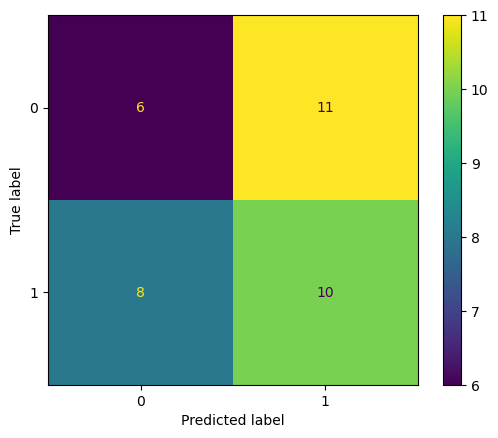

In [15]:
# Looking at just the Mean_Signal Feature
voice_feature = ['Mean_Signal']
X_downsampled = df_downsampled[voice_feature]
# Split the downsampled data into training and testing sets
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)

# Fit the classifier using the downsampled training set
knn.fit(X_train_down, y_train_down)

# Predict on the downsampled test set
y_pred_down = knn.predict(X_test_down)

# Calculate accuracy and confusion matrix using the downsampled test set
accuracy_down = accuracy_score(y_test_down, y_pred_down)
conf_matrix_down = confusion_matrix(y_test_down, y_pred_down)

print(f'Accuracy: {accuracy_down}')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_down)
disp.plot()
plt.show()

Accuracy: 0.4857142857142857


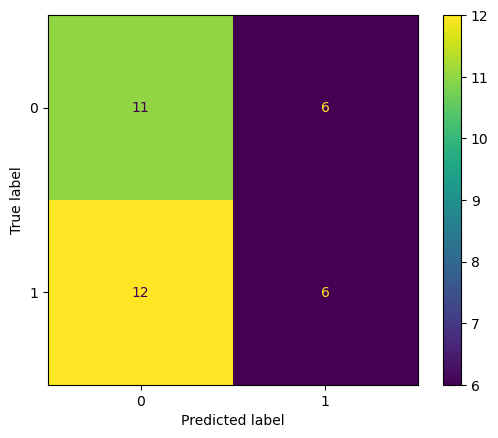

In [16]:
# Looking at just the Std_Signal Feature
voice_feature = ['Std_Signal']
X_downsampled = df_downsampled[voice_feature]
# Split the downsampled data into training and testing sets
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)

# Fit the classifier using the downsampled training set
knn.fit(X_train_down, y_train_down)

# Predict on the downsampled test set
y_pred_down = knn.predict(X_test_down)

# Calculate accuracy and confusion matrix using the downsampled test set
accuracy_down = accuracy_score(y_test_down, y_pred_down)
conf_matrix_down = confusion_matrix(y_test_down, y_pred_down)

print(f'Accuracy: {accuracy_down}')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_down)
disp.plot()
plt.show()

Accuracy: 0.45714285714285713


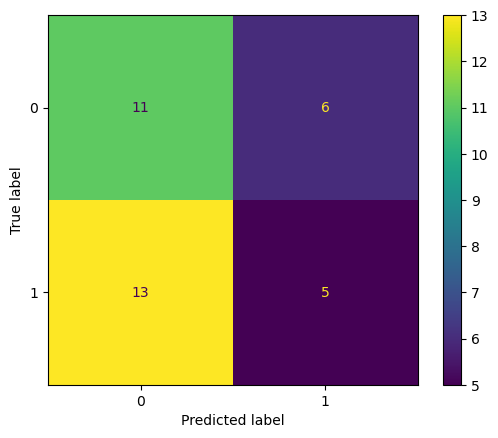

In [17]:
# Looking at just the Max_Signal Feature
voice_feature = ['Max_Signal']
X_downsampled = df_downsampled[voice_feature]
# Split the downsampled data into training and testing sets
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)

# Fit the classifier using the downsampled training set
knn.fit(X_train_down, y_train_down)

# Predict on the downsampled test set
y_pred_down = knn.predict(X_test_down)

# Calculate accuracy and confusion matrix using the downsampled test set
accuracy_down = accuracy_score(y_test_down, y_pred_down)
conf_matrix_down = confusion_matrix(y_test_down, y_pred_down)

print(f'Accuracy: {accuracy_down}')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_down)
disp.plot()
plt.show()

Accuracy: 0.6


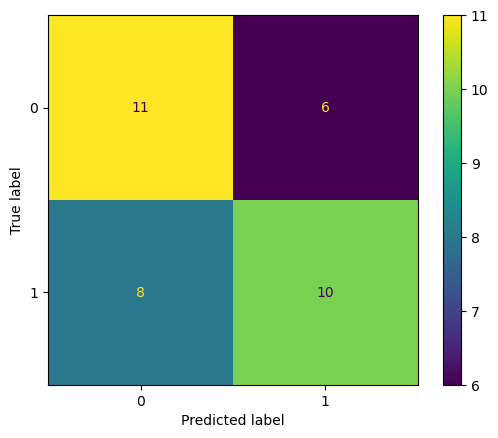

In [18]:
# Looking at just the Min_Signal Feature
voice_feature = ['Min_Signal']
X_downsampled = df_downsampled[voice_feature]
# Split the downsampled data into training and testing sets
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)


# Fit the classifier using the downsampled training set
knn.fit(X_train_down, y_train_down)

# Predict on the downsampled test set
y_pred_down = knn.predict(X_test_down)

# Calculate accuracy and confusion matrix using the downsampled test set
accuracy_down = accuracy_score(y_test_down, y_pred_down)
conf_matrix_down = confusion_matrix(y_test_down, y_pred_down)

print(f'Accuracy: {accuracy_down}')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_down)
disp.plot()
plt.show()

As we can see after getting the accuracy score of all our models using just a single feature as the X variable, we can see that the Min_Signal gave us the be accuracy score of our model and produced the best confusion matrix out of all them and it isn't close. This could signal the initial hypothesis that we had. And that is that by identifying the the minimum amplitude reflecting the lowest part of the voice recording, we can assess the dynamic range of the subject's voice and detect any abnormal vocal efforts or strain that could lead us to determine disease.

So far we have only been using one model that is the KNN classifier model. Let's see how we do with another model that being the RandomForestClassifier model. Let's first apply all the features we had originally and see how it compares to the KNN classifier 

Accuracy of the Random Forest classifier: 0.59


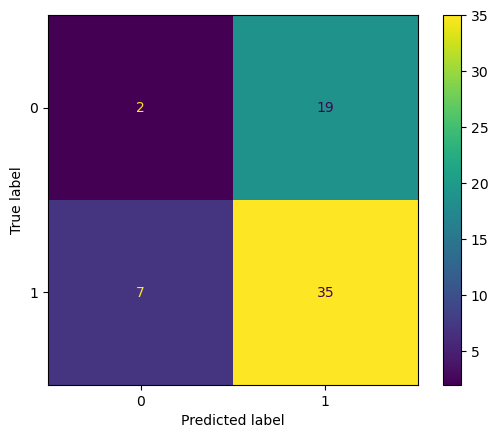

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=600, random_state=10)

# Train the model 
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)


# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Random Forest classifier: {accuracy:.2f}')

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.show()

We see that the RandomForestClassifier model has a much lower accuracy score than the KNN classifier model. It's also worth noting that this model's confusion matrix compared to the KNN ones shows us that RandomForestClassifier model could better predict non-healthy subjects but where it falls off compared to the KNN model is that it was less likely to predict healthy ones compared to non healthy ones, which is the same problem we had with our original KNN model, but in this one it seems that problem actually got worse.

Now let's once again look at individual features for the X variable but this time let's use the RandomForestClassifier Model

Accuracy of the Random Forest classifier: 0.46


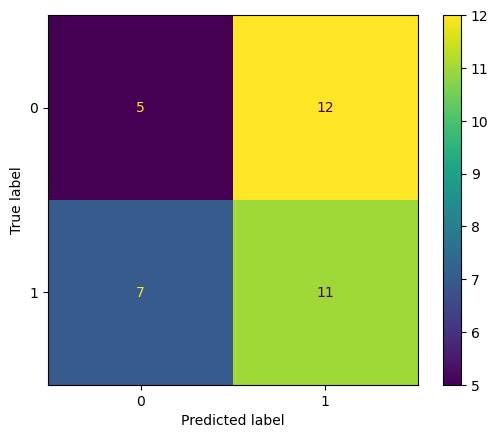

In [20]:
# Looking only at the Mean_Signal feature
voice_feature = ['Mean_Signal']
X_downsampled = df_downsampled[voice_feature]
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)

rf_classifier.fit(X_train_down, y_train_down)
y_pred = rf_classifier.predict(X_test_down)

accuracy = accuracy_score(y_test_down, y_pred)
print(f'Accuracy of the Random Forest classifier: {accuracy:.2f}')

conf_matrix = confusion_matrix(y_test_down, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.show()

Accuracy of the Random Forest classifier: 0.31


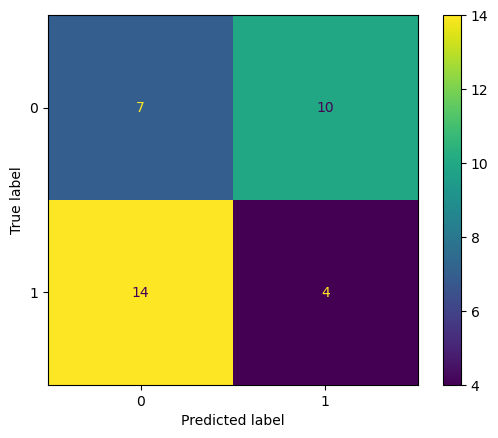

In [21]:
# Looking only at the Std_Signal feature
voice_feature = ['Std_Signal']
X_downsampled = df_downsampled[voice_feature]
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)

rf_classifier.fit(X_train_down, y_train_down)
y_pred = rf_classifier.predict(X_test_down)

accuracy = accuracy_score(y_test_down, y_pred)
print(f'Accuracy of the Random Forest classifier: {accuracy:.2f}')

conf_matrix = confusion_matrix(y_test_down, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.show()

Accuracy of the Random Forest classifier: 0.54


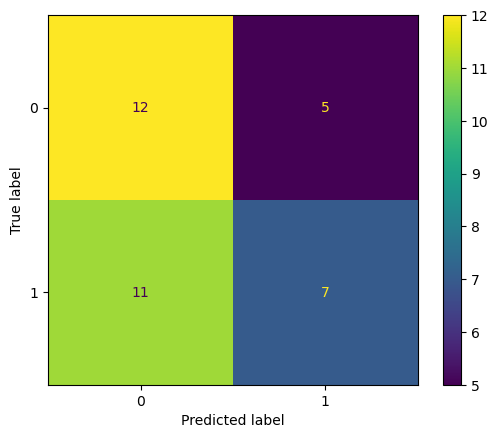

In [22]:
# Looking only at the Max_Signal feature
voice_feature = ['Max_Signal']
X_downsampled = df_downsampled[voice_feature]
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)

rf_classifier.fit(X_train_down, y_train_down)
y_pred = rf_classifier.predict(X_test_down)

accuracy = accuracy_score(y_test_down, y_pred)
print(f'Accuracy of the Random Forest classifier: {accuracy:.2f}')

conf_matrix = confusion_matrix(y_test_down, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.show()

Accuracy of the Random Forest classifier: 0.43


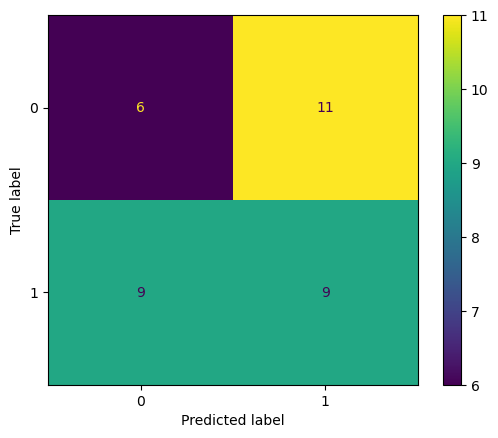

In [23]:
# Looking only at the Min_Signal feature
voice_feature = ['Min_Signal']
X_downsampled = df_downsampled[voice_feature]
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)

rf_classifier.fit(X_train_down, y_train_down)
y_pred = rf_classifier.predict(X_test_down)

accuracy = accuracy_score(y_test_down, y_pred)
print(f'Accuracy of the Random Forest classifier: {accuracy:.2f}')

conf_matrix = confusion_matrix(y_test_down, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.show()

Using the Random Forest Classifier we get very different results than the ones we got from the KNN classifier model. The feature that gave us the best results was actually the Max_Signal feature which is different than our best feature in the KNN classifier model which was the Min_Signal feature. However when comparing the accuracy between the two different results, the KNN classifier produced better results overall for mostly every feature besides the Max_Signal feature. Looking at the confusion matrix that was produced by the model in which we only used the Max_Signal feature we see that compared to the KNN model it performs significantly worse at identifying non-healthy subjects than the KNN classifier model in which we only used the Min_Signal feature. However it was able to predict more healthy subjects than the KNN classifier model. So based on this we could make a conclusion that although the RandomForestClassifier model is noticebly worse than the KNN model at prediciting non-healthy subjects however it does do a little bit at predicting healthy subjects compared to the KNN model.

Now lets try to find the best the hyperparameters for 3 different cases: The original KNN model that uses all the features, the KNN model that uses its best feature(Min_Signal), and the RandomForestClassifier model's best feature(Max_Signal)